<a href="https://colab.research.google.com/github/riyasai22/Efficient-Anomaly-Detection-in-Data-Streams/blob/main/LSTM_Autoencoders_For_Data_Stream_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle #create kaggle directory
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d uciml/electric-power-consumption-data-set

 46% 9.00M/19.4M [00:00<00:00, 13.9MB/s]
100% 19.4M/19.4M [00:00<00:00, 28.5MB/s]


In [4]:
zip_path='/content/electric-power-consumption-data-set.zip'

In [5]:
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in zip_ref.namelist():
      zip_ref.extract(member)

In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [9]:
df = pd.read_csv('household_power_consumption.txt',sep = ';',
                parse_dates={'dt':['Date','Time']},
                infer_datetime_format=True,
                low_memory=False, na_values=['nan','?'],
                index_col='dt')

In [10]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [11]:
df.shape

(2075259, 7)

In [12]:
droping_list_all=[]
for j in range(0, 7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [13]:
for j in range(0,7):
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [15]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]

        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [16]:
df_resample = df.resample('h').mean()
df_resample.shape

(34589, 7)

In [19]:
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.636816
1,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.545045
2,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.509006
3,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.488550
4,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723,0.455597


In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model, Sequential

# Split the data into training and testing sets
values = reframed.values
n_train_hours = int(len(values) * 0.8)  # Assuming an 80-20 split
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split the data into input and output
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input data for LSTM (samples, time steps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Define the LSTM Autoencoder model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(train_X.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(train_X.shape[2])))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            69632     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 64)             0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 1, 128)            98816     
                                                                 
 time_distributed (TimeDist  (None, 1, 7)              903       
 ributed)                                               

In [27]:
# Train the Autoencoder
history = model.fit(train_X, train_X, epochs=10, batch_size=128, validation_data=(test_X, test_X), verbose=1)

# Reconstruct the test data
reconstructions = model.predict(test_X)


Epoch 1/10
217/217 [==============================] - 13s 34ms/step - loss: 0.0287 - val_loss: 0.0057
Epoch 2/10
217/217 [==============================] - 4s 20ms/step - loss: 0.0073 - val_loss: 0.0040
Epoch 3/10
217/217 [==============================] - 5s 22ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 4/10
217/217 [==============================] - 6s 26ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 5/10
217/217 [==============================] - 4s 20ms/step - loss: 0.0014 - val_loss: 9.0027e-04
Epoch 6/10
217/217 [==============================] - 4s 21ms/step - loss: 6.6264e-04 - val_loss: 1.8961e-04
Epoch 7/10
217/217 [==============================] - 6s 30ms/step - loss: 2.1770e-04 - val_loss: 1.0309e-04
Epoch 8/10
217/217 [==============================] - 4s 20ms/step - loss: 1.5734e-04 - val_loss: 7.1291e-05
Epoch 9/10
217/217 [==============================] - 5s 23ms/step - loss: 1.2385e-04 - val_loss: 6.3182e-05
Epoch 10/10
217/217 [==============================] -

In [28]:

# Calculate Mean Squared Error (MSE) for each sample
mse = np.mean(np.square(test_X - reconstructions), axis=(1, 2))

# Determine a threshold for anomaly detection (e.g., using mean + 3 * std)
threshold = np.mean(mse) + 3 * np.std(mse)

# Detect anomalies based on threshold
anomalies = np.where(mse > threshold)[0]

# Print detected anomalies indices
print("Detected anomalies indices:", anomalies)


Detected anomalies indices: [  42   44  100  140  235  238  239  304  593  596  599  718  915 1249
 1266 1420 1421 1873 1894 1895 1923 1924 1925 2082 2093 2254 2396 2735
 2829 2900 2903 3077 3078 3122 3234 3337 3650 4726 4727 4817 4826 4842
 4943 5044 5108 5153 5155 5234 5235 5609 5611 5971 5972 6002 6096 6101
 6104 6117 6118 6376 6377 6520 6521 6548 6551 6770 6808 6810]


In [38]:
print(anomalies.shape)

(68,)


In [39]:
print(test_X[anomalies, 0, :].shape)

(68, 7)


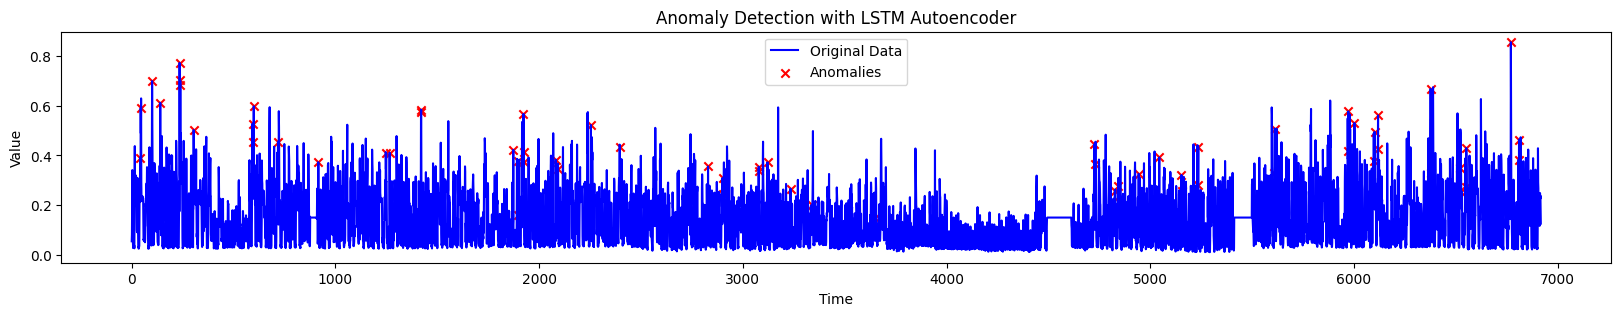

In [45]:
import matplotlib.pyplot as plt

# Plot the original data
plt.figure(figsize=(20, 3))
plt.plot(test_X[:, 0, 0], label='Original Data', color='blue')

# Plot anomalies (marked by red crosses)
plt.scatter(anomalies, test_X[anomalies, 0, 0], label='Anomalies', color='red', marker='x')

plt.title('Anomaly Detection with LSTM Autoencoder')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [46]:
# Assuming initial training on 15% of the data
initial_data = values[:int(len(values) * 0.15), :]
initial_train = initial_data[:, :-1]

# Reshape input data for LSTM
initial_train = initial_train.reshape((initial_train.shape[0], 1, initial_train.shape[1]))

# Train the initial model
model.fit(initial_train, initial_train, epochs=10, batch_size=128, verbose=1)


Epoch 1/10
41/41 [==============================] - 1s 28ms/step - loss: 7.1975e-05
Epoch 2/10
41/41 [==============================] - 1s 28ms/step - loss: 5.6553e-05
Epoch 3/10
41/41 [==============================] - 1s 18ms/step - loss: 4.3921e-05
Epoch 4/10
41/41 [==============================] - 1s 22ms/step - loss: 4.2460e-05
Epoch 5/10
41/41 [==============================] - 1s 33ms/step - loss: 3.7118e-05
Epoch 6/10
41/41 [==============================] - 1s 36ms/step - loss: 3.2355e-05
Epoch 7/10
41/41 [==============================] - 1s 35ms/step - loss: 3.1902e-05
Epoch 8/10
41/41 [==============================] - 1s 23ms/step - loss: 3.1278e-05
Epoch 9/10
41/41 [==============================] - 1s 20ms/step - loss: 2.9325e-05
Epoch 10/10
41/41 [==============================] - 1s 20ms/step - loss: 2.7739e-05


In [47]:
remaining_data = values[int(len(values) * 0.15):, :]
stream_data = remaining_data[:, :-1]
stream_data_labels = remaining_data[:, -1]

# Assuming CustomDS takes a list of samples and their labels
class CustomDS:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.current_idx = 0

    def get_next_sample(self):
        if self.current_idx < len(self.data):
            sample = self.data[self.current_idx]
            label = self.labels[self.current_idx]
            self.current_idx += 1
            return sample, label
        else:
            return None, None

stream = CustomDS(stream_data, stream_data_labels)


In [49]:
anomalies_list = []  # List to store indices of anomalies

while True:  # Simulating continuous streaming
    # Get the next sample from the stream
    sample, label = stream.get_next_sample()

    if sample is None:
        break  # End of the stream

    # Reshape the sample for prediction
    sample = sample.reshape((1, 1, sample.shape[0]))

    # Reconstruct the sample using the model
    reconstruction = model.predict(sample)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean(np.square(sample - reconstruction))

    # Determine if it's an anomaly based on the threshold
    if mse > threshold:
        print(f"Detected anomaly at index {stream.current_idx - 1}, Label: {label}")
        anomalies_list.append(stream.current_idx - 1)  # Append the anomaly index


anomalies = np.array(anomalies_list)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step
Detected anomaly at index 25819, Label: 0.08011041140158262
1/1 [==============================] - 0s 69ms/step
Detected anomaly at index 28583, Label: 0.23793864191904537
1/1 [==============================] - 0s 40ms/step
Detected anomaly at index 28586, Label: 0.30824046070348426
1/1 [==============================] - 0s 35ms/step
Detected anomaly at index 28858, Label: 0.333751087541948
1/1 [==============================] - 0s 35ms/step
Detected anomaly at index 28870, Label: 0.6105408708621617
1/1 [==============================] - 0s 41ms/step
Detected anomaly at index 29030, Label: 0.3887858888842855
1/1 [==============================] - 0s 30ms/step
Detected anomaly at index 29252, Label: 0.2596584082528897
1/1 [==============================] - 0s 33ms/step


In [57]:
print(test_X.shape[0])

6918


In [54]:
print(anomalies.shape)

(56,)


[5080, 5533, 6407, 6428, 6569, 6807]


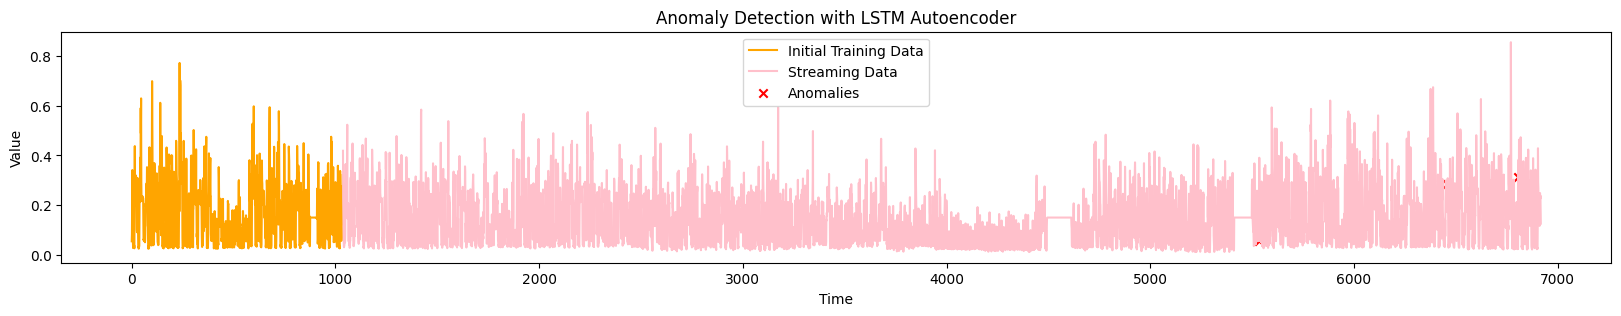

In [78]:
# Plot the original data
plt.figure(figsize=(20, 3))
split_index = int(len(test_X) * 0.15)

plt.plot(test_X[:split_index, 0, 0], label='Initial Training Data', color='orange')
plt.plot(range(split_index, len(test_X)), test_X[split_index:, 0, 0], label='Streaming Data', color='pink')

valid_anomalies = [idx for idx in anomalies if idx < test_X.shape[0]]
print(valid_anomalies)
#print(test_X[anomalies, 0, 0])
plt.scatter(valid_anomalies, test_X[valid_anomalies, 0, 0], label='Anomalies', color='red', marker='x')
plt.title('Anomaly Detection with LSTM Autoencoder')
plt.xlabel('Time')
plt.ylabel('Value')

plt.legend()
plt.show()